In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geopy.distance
import multiprocessing
from multiprocessing import Pool

In [2]:
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.model_selection import train_test_split 

In [3]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:98% !important; }</style>"))

In [4]:
from tqdm import tqdm
tqdm.pandas()

## Load training data

In [5]:
train_data = pd.read_csv("/home/nihaln.karne/Personal_practice/Kaggle_nyc_taxi/nyc-taxi-trip-duration/train.csv" , date_parser=True)
print("Train Shape: " , train_data.shape)
train_data.head()

Train Shape:  (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


## Univariate analysis

### Understanding the distribution of vendor_id in training data

vendor_id
1    678342
2    780302
dtype: int64


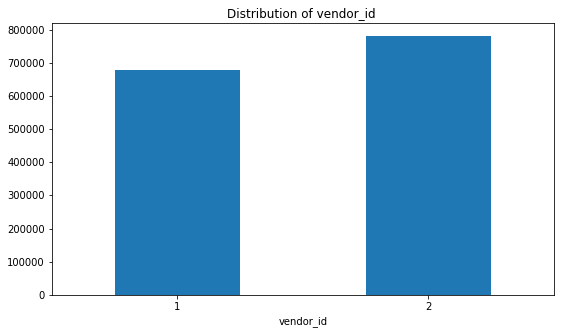

In [7]:
data = train_data.groupby(['vendor_id']).size()
print(data)

plt.figure(figsize=(9,5))
data.plot.bar()
plt.title("Distribution of vendor_id ")
plt.xticks(rotation=0)
plt.show()

### Understanding the distribution of passenger_count in training data

passenger_count
0         60
1    1033540
2     210318
3      59896
4      28404
5      78088
6      48333
7          3
8          1
9          1
dtype: int64


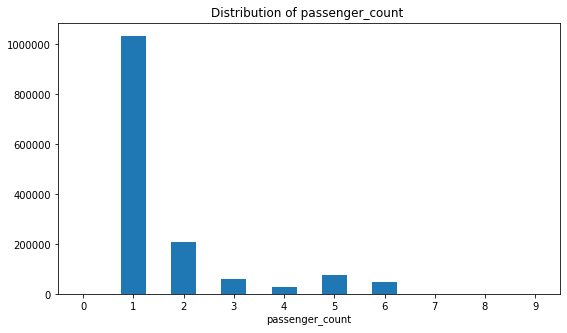

In [8]:
data = train_data.groupby(['passenger_count']).size()
print(data)

plt.figure(figsize=(9,5))
data.plot.bar()
plt.title("Distribution of passenger_count ")
plt.xticks(rotation=0)
plt.show()

### Understanding the distribution of store_and_fwd_flag in training data

store_and_fwd_flag
N    1450599
Y       8045
dtype: int64


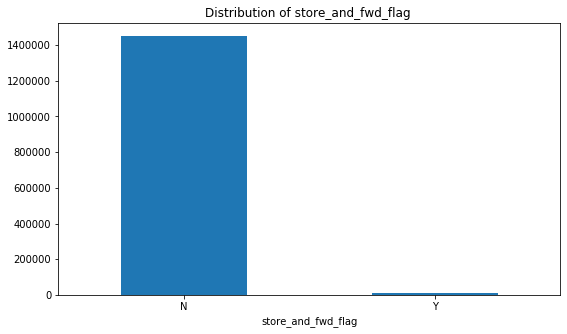

In [9]:
data = train_data.groupby(['store_and_fwd_flag']).size()
# data = train_data.store_and_fwd_flag.value_counts(normalize=True)
print(data)

plt.figure(figsize=(9,5))
data.plot.bar()
plt.title("Distribution of store_and_fwd_flag ")
plt.xticks(rotation=0)
plt.show()

### Understanding the range of pickup and dropoff datetime in training data

In [10]:
print("Pickup_datetime Range: ")
train_data.pickup_datetime.agg(['min','max'])

Pickup_datetime Range: 


min    2016-01-01 00:00:17
max    2016-06-30 23:59:39
Name: pickup_datetime, dtype: object

In [11]:
print("dropoff_datetime Range: ")
train_data.dropoff_datetime.agg(['min','max'])

dropoff_datetime Range: 


min    2016-01-01 00:03:31
max    2016-07-01 23:02:03
Name: dropoff_datetime, dtype: object

### Understanding distributuion of trip_duration in training data

Text(0.5, 1.0, 'Histogram of trip_duration')

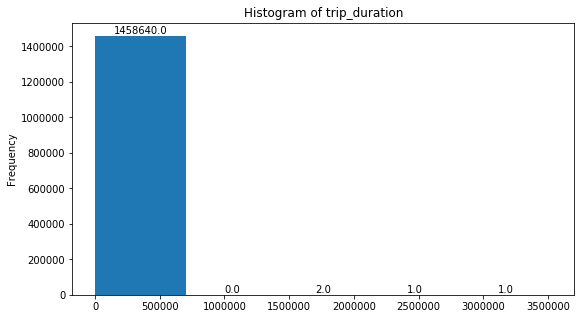

In [12]:
plt.figure(figsize=(9,5))
ax = train_data.trip_duration.plot.hist(bins=5)
for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, height,
            ha='center', va='bottom')
plt.title("Histogram of trip_duration")

In [13]:
train_data.trip_duration.agg(['min','max'])

min          1
max    3526282
Name: trip_duration, dtype: int64

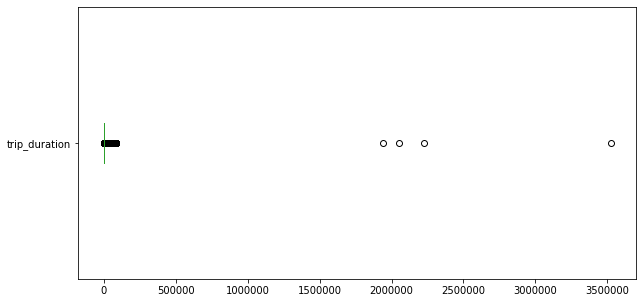

In [14]:
train_data.trip_duration.plot.box(vert=False, figsize=(10,5))

### Considering distance between pickup and dropoff point

In [15]:
def cal_km(geo_points):
    
    coord_1 = (geo_points[0],geo_points[1])
    coord_2 = (geo_points[2],geo_points[3])
    try:
        d = geopy.distance.geodesic(coord_1, coord_2).km
        return d
    
    except Exception as e:
        return np.NaN

In [16]:
geo_data = []
for plong,plat,dlong,dlat in zip(train_data.pickup_longitude, train_data.pickup_latitude,
                                 train_data.dropoff_longitude, train_data.dropoff_latitude):    
    point = (plat,plong,dlat,dlong)
    geo_data.append(point)
    
print("CPU count: ", multiprocessing.cpu_count())
start_time = time.time()

with Pool(6) as p:
    distance = p.map(cal_km, geo_data)

print("Computation time: {:.2f} seconds".format(time.time() - start_time)) 

# adding column to train data
train_data['distance'] = distance

CPU count:  8
Computation time: 70.63 seconds


Text(0.5, 1.0, 'Boxplot for distance feature')

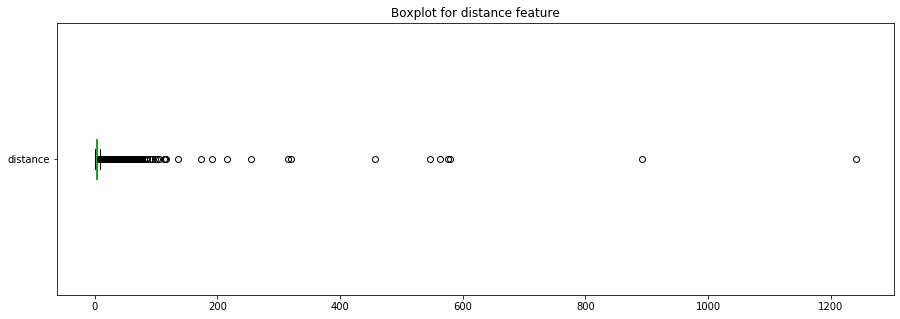

In [17]:
train_data.distance.plot.box(vert=False, figsize=(15,5))
plt.title("Boxplot for distance feature")

### Considering pickup and dropoff locations in forms of groups(Clusters)

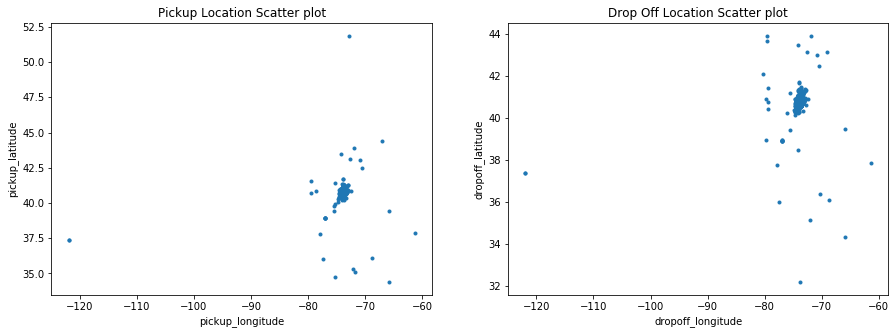

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# Pickup Location Scatter plot
ax[0].scatter(train_data['pickup_longitude'], train_data['pickup_latitude'], marker='.')
ax[0].set_title('Pickup Location Scatter plot')
ax[0].set_xlabel('pickup_longitude')
ax[0].set_ylabel('pickup_latitude')

# Drop Off Location Scatter plot
ax[1].scatter(train_data['dropoff_longitude'], train_data['dropoff_latitude'], marker='.')
ax[1].set_title('Drop Off Location Scatter plot')
ax[1].set_xlabel('dropoff_longitude')
ax[1].set_ylabel('dropoff_latitude')

plt.show()

In [19]:
# fitting multiple k-means algorithms and storing the values in an empty list
def Calculate_SSE(data, end_k=30):
    SSE = []
    for cluster in range(1,end_k):
        kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
        kmeans.fit(data)
        SSE.append(kmeans.inertia_)
    
    return SSE

In [20]:
pickup_SSE = Calculate_SSE(train_data[['pickup_longitude','pickup_latitude']])

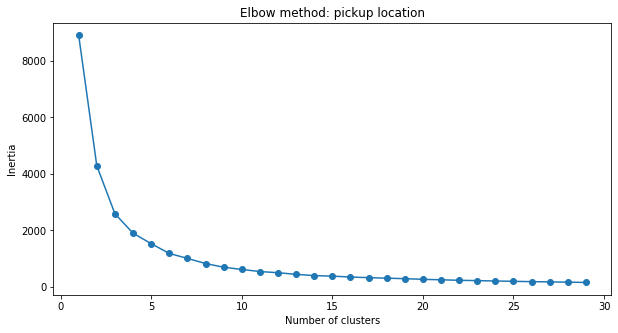

In [21]:
# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,30), 'SSE':pickup_SSE})

plt.figure(figsize=(10, 5))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.title("Elbow method: pickup location")
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### Insight: Lets consider k=6

In [22]:
kmeans = KMeans(n_jobs = -1, n_clusters = 6, init='k-means++')
kmeans.fit(train_data[['pickup_longitude','pickup_latitude']])
pred = kmeans.predict(train_data[['pickup_longitude','pickup_latitude']])

In [23]:
train_data['pickup_cluster'] = pred
print("Cluster-wise count for pickup location:")
train_data['pickup_cluster'].value_counts()

Cluster-wise count for pickup location:


0    709847
3    669733
5     45751
2     33306
4         5
1         2
Name: pickup_cluster, dtype: int64

In [24]:
dropoff_SSE = Calculate_SSE(train_data[['dropoff_longitude','dropoff_latitude']])

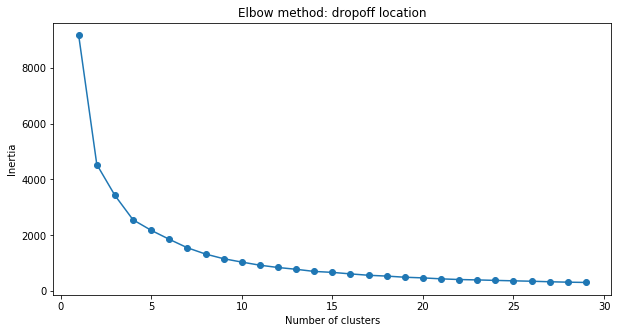

In [25]:
# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,30), 'SSE':dropoff_SSE})

plt.figure(figsize=(10, 5))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.title("Elbow method: dropoff location")
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### Insight: Lets consider k=6

In [26]:
kmeans = KMeans(n_jobs = -1, n_clusters = 6, init='k-means++')
kmeans.fit(train_data[['dropoff_longitude','dropoff_latitude']])
pred = kmeans.predict(train_data[['dropoff_longitude','dropoff_latitude']])

In [27]:
train_data['dropoff_cluster'] = pred
print("CLuster-wise count for dropoff location:")
train_data['dropoff_cluster'].value_counts()

CLuster-wise count for dropoff location:


0    719342
3    373231
5    312797
1     53265
4         7
2         2
Name: dropoff_cluster, dtype: int64

## Bivariate analysis

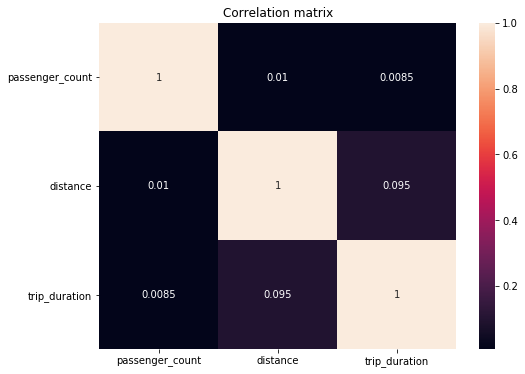

In [28]:
corr = train_data[["passenger_count", "distance", "trip_duration"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True)
plt.title("Correlation matrix")
plt.yticks(rotation=0)
plt.show()